# TODO
- Figure our why end point loads exceeding 1
    - Think must be that max_total_ep_info and corresponding max_total_port_info and target loads of pairs are incorrect/inconsistent?
- Clean up vectorised code and merge any initialisation loops in pack_the_flows() into reset() and into one single loop through pairs where possible

12800000.0


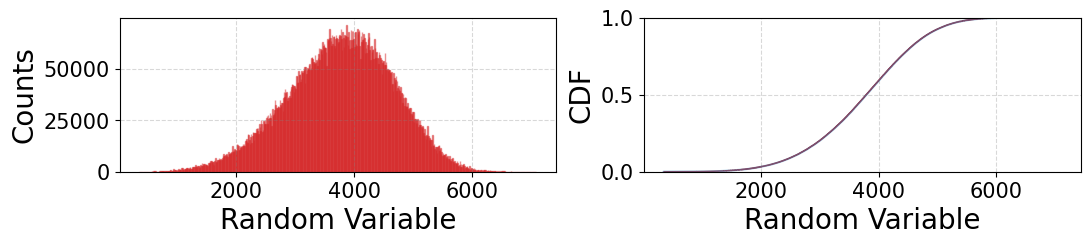

net.graph endpoint types: <class 'str'>


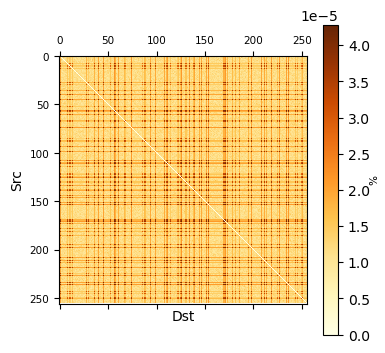

<Figure size 640x480 with 0 Axes>

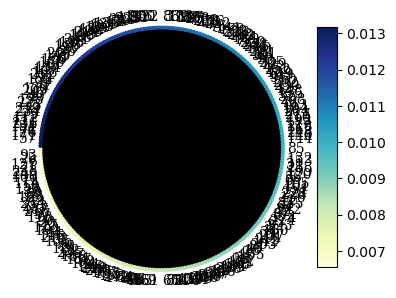

In [1]:
%load_ext autoreload
%autoreload
from trafpy.generator import Demand, DemandPlotter
import trafpy.generator as tpg
import time
import copy
from scipy.io import savemat


sid = 1
# set vars
X = 4
N = 64*X
# path = r'Y:/Joshua/Traffic/'
path = 'Y:/Joshua/Traffic/'
endpoints = [str(i) for i in range(N)]

min_num_demands = 100
min_last_demand_arrival_time = None
# loads = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]A
loads = [0.9]
jensen_shannon_distance_threshold = 0.3
# jensen_shannon_distance_threshold = 0.1
NUM_DEMANDS_FACTOR = 5

sk_nd = [0, 0.25,0.5,0.75, 0.5625,0.8125,0.3125, 0.5625,0.8125]
sk_pr = [1, 0.64,0.64,0.64,0.16,0.16,0.32,0.32,0.32]

SN = sk_nd[sid-1]
SK = sk_pr[sid-1]
# num_skewed_nodes=int(len(endpoints)*SN)

# init network
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=N, ep_capacity=100000)
print(net.graph['max_nw_capacity'])

# set any distributions you want to keep constant for all sets
flow_size_dist, _ = tpg.gen_named_val_dist(dist='weibull',
                                        params={'_alpha': 4.8, '_lambda': 4100},
                                        return_data=False,
                                        show_fig=True,
                                        round_to_nearest=1)

interarrival_time_dist = {0.125:1}

# node_dist = tpg.gen_uniform_node_dist(eps=net.graph['endpoints'],
#                                          show_fig=False)    

print(f'net.graph endpoint types: {type(net.graph["endpoints"][0])}')
# raise Exception()
node_dist, _ = tpg.gen_multimodal_node_dist(eps=net.graph['endpoints'],
                                         skewed_nodes=[],
                                         skewed_node_probs=[SK/(SN*N) for _ in range(int(SN*N))],
                                         # show_fig=False,
                                         show_fig=True,
                                         num_skewed_nodes=int(SN*N))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating load 0.9...


Packed 8540 flows in 46.86778545379639 s.


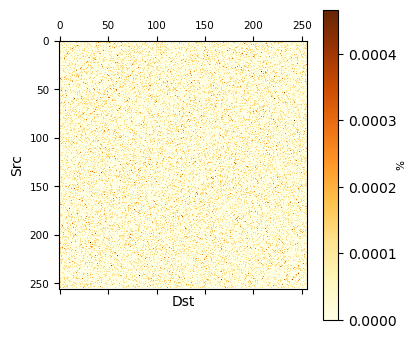

<Figure size 640x480 with 0 Axes>

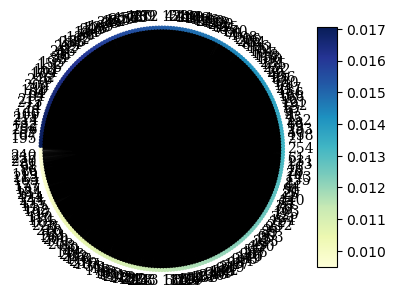

<Figure size 640x480 with 0 Axes>

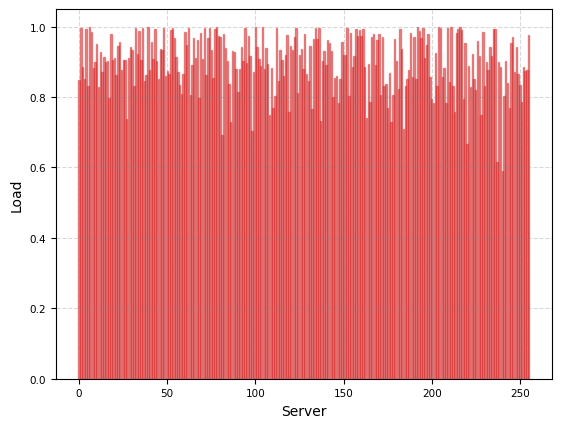

<Figure size 640x480 with 0 Axes>

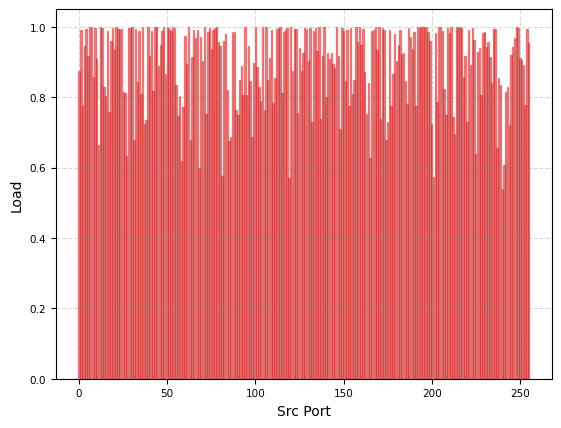

<Figure size 640x480 with 0 Axes>

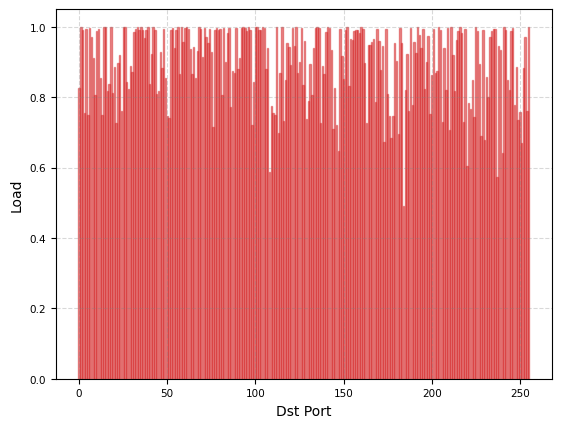

Generated load 0.9 in 57.6931517124176 seconds.


In [2]:
%load_ext autoreload
%autoreload


for load in loads:
    print('Generating load {}...'.format(load))
    
    start = time.time()
    
    network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                           'ep_link_capacity': net.graph['ep_link_capacity'],
                           'target_load_fraction': load}
    flow_centric_demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                                      node_dist=node_dist,
                                                      flow_size_dist=flow_size_dist,
                                                      interarrival_time_dist=interarrival_time_dist,
                                                      network_load_config=network_load_config,
                                                      jensen_shannon_distance_threshold=jensen_shannon_distance_threshold,
                                                      min_num_demands=min_num_demands,
                                                      min_last_demand_arrival_time=min_last_demand_arrival_time,
                                                      check_dont_exceed_one_ep_load=True,
                                                      auto_node_dist_correction=True,
                                                      print_data=True)

    demand = Demand(flow_centric_demand_data, net.graph['endpoints'])
    plotter = DemandPlotter(demand)
    plotter.plot_node_dist(eps=net.graph['endpoints'])
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])
    
    # save generated demands
    # savemat("custom/uniform/load{}_N{}_matlab_matrix.mat".format(load, N), flow_centric_demand_data)
    
    end = time.time()
    print('Generated load {} in {} seconds.'.format(load, end-start))

In [3]:
print(end-start)

57.6931517124176


In [4]:
import numpy as np

srcs = [f'src_{i}' for i in range(1, 4)]
dsts = [f'dst_{i}' for i in range(1, 4)]
pairs = []
for src in srcs:
    for dst in dsts:
        if src != dst:
            pairs.append(f'{src}-{dst}')
print(f'srcs ({len(srcs)}): {srcs}')
print(f'dsts ({len(dsts)}): {dsts}')
print(f'pairs ({len(pairs)}): {pairs}')

srcs_mask = [0, 0, 1]
dsts_mask = [1, 1, 1]

pairs_grid = np.meshgrid(srcs, dsts, indexing='xy')
print(f'pairs_grid:\n{pairs_grid}')

srcs (3): ['src_1', 'src_2', 'src_3']
dsts (3): ['dst_1', 'dst_2', 'dst_3']
pairs (9): ['src_1-dst_1', 'src_1-dst_2', 'src_1-dst_3', 'src_2-dst_1', 'src_2-dst_2', 'src_2-dst_3', 'src_3-dst_1', 'src_3-dst_2', 'src_3-dst_3']
pairs_grid:
[array([['src_1', 'src_2', 'src_3'],
       ['src_1', 'src_2', 'src_3'],
       ['src_1', 'src_2', 'src_3']], dtype='<U5'), array([['dst_1', 'dst_1', 'dst_1'],
       ['dst_2', 'dst_2', 'dst_2'],
       ['dst_3', 'dst_3', 'dst_3']], dtype='<U5')]
